# Inverse Noise Weighting

Say you have **M measurements** with some noise and **N parameters** that you need to fit for.

$$ g_i g_j^* V_{ij}^M = V_{ij} + n_{ij} = V_{ij}' $$
$$ g_l g_m^* V_{ij}^M = V_{lm} + n_{lm} = V_{lm}' \dots{}$$

The system of equations can be represented by the matrix equation:
$$ [A]_{M\times N}[X]_{N\times 1} = [Y]_{M\times 1} $$

where A is the matrix of coefficients, X is the matrix of parameters ($g_i$, $g_j$, ... $V_{ij}$... ) and Y is matrix of measurement results which are noisy (with unknown noise properties in general).

The solution of the system of linear equations is given by:
$$ X = (A^{\dagger}N^{-1}A)^{-1}A^{\dagger}N^{-1}Y$$


$$N = nn^{\dagger}$$

## Noise matrix

The noise matrix is defined as:
$$N = \langle nn^{\dagger} \rangle$$

The angular brackets denote a statistical ensemble average but since each measurement is theoretically assumed to be independent, this can be estimated from a time average also. In the strictest terms, the probability distribution function of the noise in the data should be determined and the noise matrix is the this is the mean of that distribution. More practically, it is the expectation value of the noise for different measurements.

Some properties of the noise matrix:

1. Is a diagonal matrix if there is no covariance.
2. Is proportional to the identity matrix if all measurements have the same noise. $N = nI$
3. If the noise is drawn from a normal distribution, the chi squared is given by the exponent of a guassian.

# SVD analysis for HERA antenna layout

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
import hera_cal

Nants = 37

ants = np.loadtxt('antenna_positions_%d.dat'%Nants)
idxs = np.arange(Nants)
antpos = {}
for k,v in zip(idxs,ants):
    antpos[k] = v
    
redbls = hera_cal.redcal.get_pos_reds(antpos)

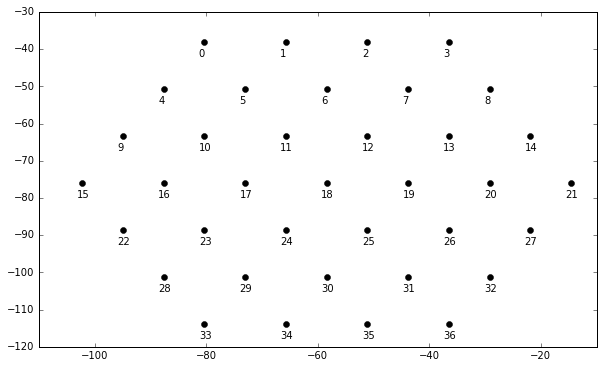

In [3]:
#Check out the layout
def plot_ants(antpos):
    for k,v in antpos.items():
        plt.plot(v[0],v[1],'ko')
        plt.annotate('%d'%k,xy=(v[0],v[1]),xytext=(v[0]-1,v[1]-4))
plt.figure(4)
plot_ants(antpos)

In [4]:
def genA(redbls):
    # number of measurements = total number of baselines
    M = 0
    for i in range(len(redbls)):
        M += len(redbls[i])
    
    # number of parameters = num_ants + num_unique baselines
    N = Nants + len(redbls)
    
    A = np.zeros([M,N],dtype=np.complex)
    i = 0
    for bl,reds in enumerate(redbls):
        for pair in reds:
            A[i,pair[0]] = 1+1j
            A[i,pair[1]] = 1-1j
            A[i,Nants+bl] = 1+1j
            i += 1
    return np.matrix(A)

In [22]:
A = genA(redbls)
print "Number of measurements: %d"%np.shape(A)[0]
print "Number of parameters: %d"%np.shape(A)[1]

Number of measurements: 666
Number of parameters: 100


In [23]:
M = np.dot(np.real(A).T,np.real(A))

# Eigen Spectrum

The Eigen spectrum shows how well constrained the parameters are. Higher the eigen value, lower the noise on that parameter. Degenerate parameters have an eigen value of zero, implying that they cannot be constained at all.

In [24]:
U,S,V = np.linalg.svd(M)

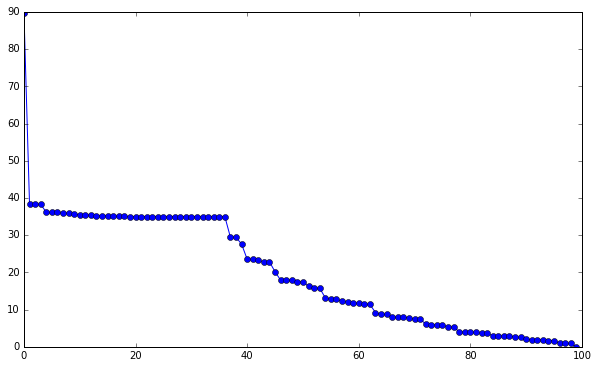

In [25]:
plt.figure(2)
plt.plot(S,'o-')
plt.show()

# Eigen vectors

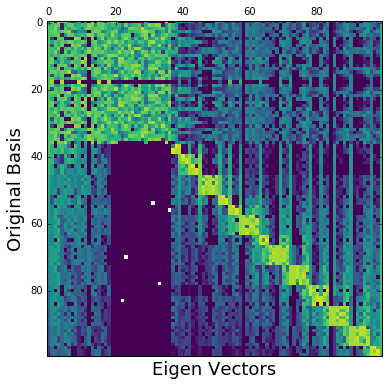

In [26]:
import warnings
warnings.filterwarnings('ignore')
plt.matshow(np.log10(np.abs(U)),vmax=0,vmin=-3,cmap='viridis')
plt.xlabel('Eigen Vectors',fontsize=18)
plt.ylabel('Original Basis',fontsize=18)

# Covariance in the estimated g,V

The gains and visibilities estimated from the given set of measurements are given by:
$$\hat{X} = (A^{\dagger}N^{-1}A)^{-1} A^{\dagger}N^{-1}Y$$

The covariance of $\hat{X}$, that is the variance in the estimated parameters can be derived as:

$$\text{Cov}(X) = (A^{\dagger}N^{-1}A)^{-1} $$

In [27]:
Sinv = [s**-1 if s>10**-11 else 0 for s in S]
Minv = np.einsum('nm,m,mp->np',V.T,Sinv,U.T)

#### Why is M.Minv not 1?

The eigen value that is zero could not be inverted and you took the pseudo inverse (substituting the zero for zero). This missing eigen value can been seen similar to a missing channel in a frequency spectrum. When you inverse fourier transform a missing channel, you get a sine-like feature in your time domain. Here you get the corresponding eigen vector like feature in the product! Cool, right?

In [28]:
np.einsum('nm,mp',Minv,M)

array([[ 0.99653979, -0.00346021, -0.00346021, ...,  0.00692042,
         0.00692042,  0.00692042],
       [-0.00346021,  0.99653979, -0.00346021, ...,  0.00692042,
         0.00692042,  0.00692042],
       [-0.00346021, -0.00346021,  0.99653979, ...,  0.00692042,
         0.00692042,  0.00692042],
       ..., 
       [ 0.00692042,  0.00692042,  0.00692042, ...,  0.98615917,
        -0.01384083, -0.01384083],
       [ 0.00692042,  0.00692042,  0.00692042, ..., -0.01384083,
         0.98615917, -0.01384083],
       [ 0.00692042,  0.00692042,  0.00692042, ..., -0.01384083,
        -0.01384083,  0.98615917]])

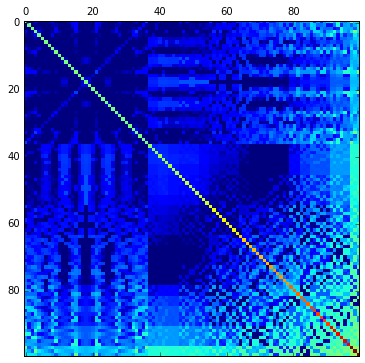

In [29]:
plt.matshow(np.log10(np.abs(Minv)),vmax=0,vmin=-3)

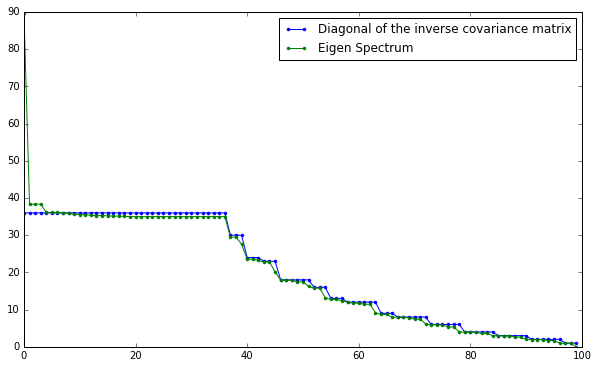

In [30]:
plt.figure(6)
plt.plot(np.diag(M),'.-',label='Diagonal of the inverse covariance matrix')
plt.plot(S,'.-',label='Eigen Spectrum')
plt.legend()
plt.show()

# Integration time

The covariance (or variance if you consider the eigen modes) is given by: 
$$\text{Cov}(\hat{X}) = (A^{\dagger}N^{-1}A)^{-1} = \frac{T_{sys}^2}{Bt}(A^{\dagger}A)^{-1}$$

The signal amplitude is just $T_{src}$. Combining the two in the right units:

$$\text{SNR}^2 = \frac{Bt T_{src}^2}{T_{sys}^2}(A^{\dagger}A)$$

From this you can compute the integration time required for an SNR of unity.

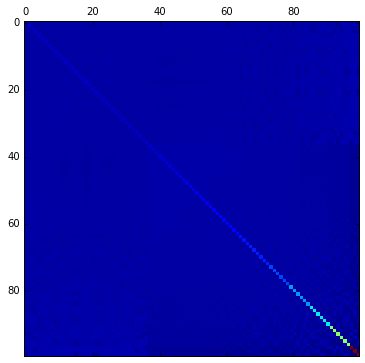

In [31]:
# Integration time

Tsys = 500
Tsrc = 5
B = 250e6/4096

t = Tsys**2/(B*Tsrc**2)*Minv
plt.matshow(t)

In [15]:
t = Tsys**2/(B*Tsrc**2)*np.asarray(Sinv)
print t

[ 0.0018252   0.00427167  0.00427377  0.00427377  0.00453346  0.0045371
  0.0045371   0.0045623   0.0045623   0.00460481  0.00461019  0.00461019
  0.00463913  0.00464541  0.00464541  0.00465304  0.00466344  0.00466344
  0.00467389  0.00468114  0.00468114  0.00468114  0.00468114  0.00468114
  0.00468114  0.00468114  0.00468114  0.00468114  0.00468114  0.00468114
  0.00468114  0.00468114  0.00468114  0.00468114  0.00468114  0.00468114
  0.00468114  0.00556138  0.00556138  0.00593298  0.00695838  0.00695838
  0.00705543  0.00718022  0.00718022  0.00811604  0.00915251  0.00915251
  0.00916002  0.00937522  0.00937522  0.01008183  0.01039866  0.01039866
  0.01242541  0.012872    0.012872    0.01326651  0.01365333  0.01396791
  0.01396791  0.01433668  0.01433668  0.0178739   0.01883837  0.01883837
  0.02060091  0.02060091  0.02066288  0.02095739  0.02209394  0.02209394
  0.02665065  0.02763043  0.02775199  0.02775199  0.03074946  0.03074946
  0.04046178  0.04183115  0.04183115  0.04222546  0.

# Use only the shortest baseline

**The very shortest baseline - (0,5) type has only 30 redundant baselines. There are fewer equations than variables to solve for. You need to use at least the first two types of redundant baselines to build enough equations.**

In [32]:
#Select the reds for the shortest baseline-- 
shortest_bl = [rbl for rbl in redbls if (1,0) in rbl or (5,0) in rbl]
print "Number of measurements: %d"%len(shortest_bl[0]+shortest_bl[1])

Atrunc = genA(shortest_bl)
Mtrunc_real = np.dot(np.real(Atrunc).T,np.real(Atrunc))
Mtrunc_imag = np.dot(np.imag(Atrunc).T,np.imag(Atrunc))

Number of measurements: 60


In [33]:
Ut,St,Vt = np.linalg.svd(Mtrunc_real)

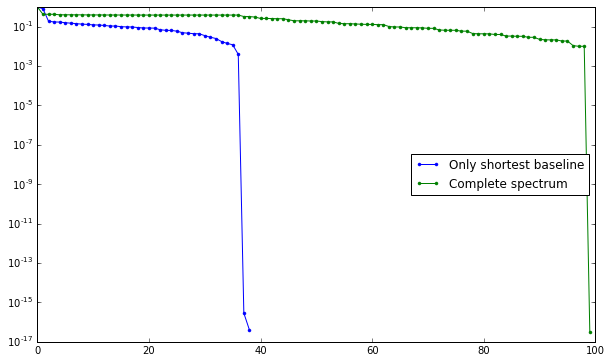

In [34]:
plt.figure(8)
plt.semilogy(St/St.max(),'.-',label='Only shortest baseline')
plt.semilogy(S/S.max(),'.-',label='Complete spectrum')
plt.legend(loc=7)
plt.show()

In [19]:
import warnings
warnings.filterwarnings('ignore')
plt.matshow(np.log10(np.abs(Ut)),vmax=0,vmin=-3,aspect='equal',cmap='viridis')
#plt.colorbar(orientation='horizontal')
plt.xlabel('Eigen Vectors',fontsize=16)
plt.ylabel('Original Basis',fontsize=16)

NameError: name 'Ut' is not defined

In [35]:
print Ut[:,37].T 
print Ut[:,38].T

[[ 0.21310511  0.00102835  0.21310511  0.00102835  0.21310511  0.00102835
   0.21310511  0.00102835  0.21310511  0.21310511  0.00102835  0.21310511
   0.00102835  0.21310511  0.00102835  0.21310511  0.00102835  0.21310511
   0.00102835  0.21310511  0.00102835  0.21310511  0.00102835  0.21310511
   0.00102835  0.21310511  0.00102835  0.21310511  0.21310511  0.00102835
   0.21310511  0.00102835  0.21310511  0.00102835  0.21310511  0.00102835
   0.21310511 -0.21413346 -0.21413346]]
[[ 0.02190736 -0.23051906  0.02190736 -0.23051906  0.02190736 -0.23051906
   0.02190736 -0.23051906  0.02190736  0.02190736 -0.23051906  0.02190736
  -0.23051906  0.02190736 -0.23051906  0.02190736 -0.23051906  0.02190736
  -0.23051906  0.02190736 -0.23051906  0.02190736 -0.23051906  0.02190736
  -0.23051906  0.02190736 -0.23051906  0.02190736  0.02190736 -0.23051906
   0.02190736 -0.23051906  0.02190736 -0.23051906  0.02190736 -0.23051906
   0.02190736  0.20861171  0.20861171]]


[ 0.00443147  0.00543359  0.02344682  0.02540825  0.02584025  0.02780183
  0.02932794  0.03112205  0.03278867  0.03393724  0.03585895  0.03636555
  0.03846643  0.04096     0.04096     0.04430067  0.04528772  0.04598194
  0.04887327  0.05145749  0.05177378  0.05242141  0.06300888  0.06785192
  0.06856268  0.07474162  0.08940437  0.09469535  0.10029007  0.10134079
  0.12601749  0.15169246  0.17624782  0.25094904  0.31266593  0.36606768
  1.11914028  0.          0.        ]


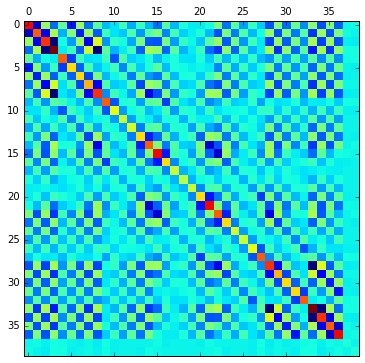

In [36]:
# Integration time with the shortest baseline
Stinv = [s**-1 if s>10**-11 else 0 for s in St]
Mtinv = np.einsum('nm,m,mp->np',Vt.T,Stinv,Ut.T) 

Tsys = 500
Tsrc = 5
B = 250e6/4096

t = Tsys**2/(B*Tsrc**2)*Mtinv
plt.matshow(t)

print Tsys**2/(B*Tsrc**2)*np.asarray(Stinv)